Борисенко Дмитрий Антонович РИ-230945

# Imports

In [ ]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
import random
import cv2
from PIL import Image, ImageEnhance, ImageOps
from collections import defaultdict
from tqdm import tqdm

# Utils

In [ ]:
def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    images = images[:nrow]

    # Увеличиваем изображения до 128x128 для лучшей видимости
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]

    # Создаем сетку изображений
    fig, axes = plt.subplots(1, nrow, figsize=(nrow*2, 2))
    if nrow == 1:
        axes = [axes]

    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        # Нормализуем для отображения
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_single_augmentation(original_img, augmented_img, title="Аугментация"):
    """Визуализирует оригинальное и аугментированное изображение рядом."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Увеличиваем изображения
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    aug_resized = resize_transform(augmented_img)

    # Оригинальное изображение
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    ax1.imshow(orig_np)
    ax1.set_title("Оригинал")
    ax1.axis('off')

    # Аугментированное изображение
    aug_np = aug_resized.numpy().transpose(1, 2, 0)
    aug_np = np.clip(aug_np, 0, 1)
    ax2.imshow(aug_np)
    ax2.set_title(title)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

def show_multiple_augmentations(original_img, augmented_imgs, titles):
    """Визуализирует оригинальное изображение и несколько аугментаций."""
    n_augs = len(augmented_imgs)
    fig, axes = plt.subplots(1, n_augs + 1, figsize=((n_augs + 1) * 2, 2))

    # Увеличиваем изображения
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)

    # Оригинальное изображение
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    axes[0].imshow(orig_np)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    # Аугментированные изображения
    for i, (aug_img, title) in enumerate(zip(augmented_imgs, titles)):
        aug_resized = resize_transform(aug_img)
        aug_np = aug_resized.numpy().transpose(1, 2, 0)
        aug_np = np.clip(aug_np, 0, 1)
        axes[i + 1].imshow(aug_np)
        axes[i + 1].set_title(title)
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Dataset

In [ ]:
class CustomImageDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""

    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Получаем список классов (папок)
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Собираем все пути к изображениям
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_names(self):
        """Возвращает список имен классов"""
        return self.classes

# Задание 1: Стандартные аугментации torchvision

Создайте пайплайн стандартных аугментаций torchvision (например, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomRotation, RandomGrayscale).

Примените аугментации к 5 изображениям из разных классов (папка train).

Визуализируйте:

  - Оригинал
  - Результат применения каждой аугментации отдельно
  - Результат применения всех аугментаций вместе


In [ ]:
# Загрузка датасета без аугментаций
root = './drive/MyDrive/hero_dataset/train/'
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))
print("Total images in dataset:", len(dataset))
class_names = dataset.get_class_names()
class_samples = []
for class_idx, class_name in enumerate(class_names):
    # Находим индекс первого изображения этого класса
    sample_idx = dataset.labels.index(class_idx)
    image, label = dataset[sample_idx]
    class_samples.append((image, class_name))

Total images in dataset: 180


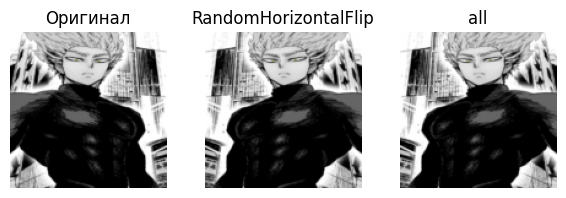

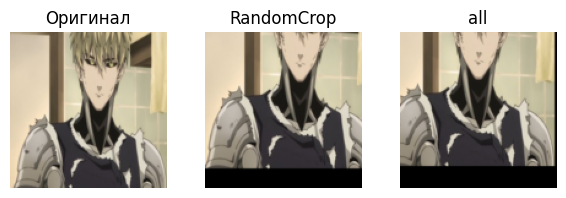

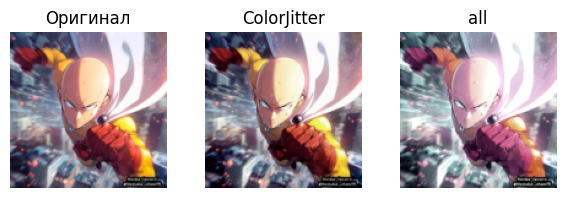

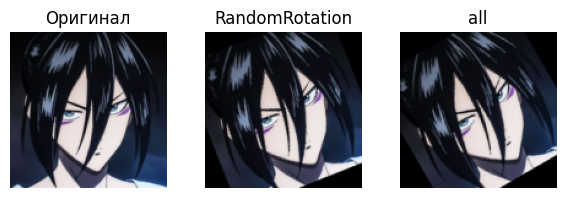

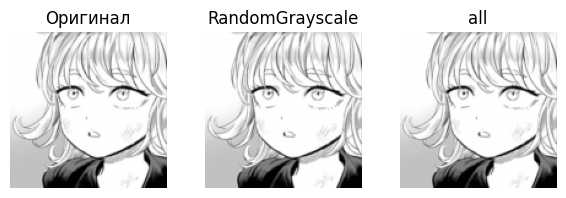

In [ ]:
standard_augs = [
    ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=1.0)),
    ("RandomCrop", transforms.RandomCrop(200, padding=30)),
    ("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
    ("RandomRotation", transforms.RandomRotation(degrees=50)),
    ("RandomGrayscale", transforms.RandomGrayscale(p=1.0))
]

for (name, aug), (img, cls_name) in zip(standard_augs, class_samples):
    augmented_imgs = []
    titles = []

    aug_transform1 = transforms.Compose([
        aug,
        transforms.ToTensor()
    ])
    aug_img1 = aug_transform1(img)
    augmented_imgs.append(aug_img1)
    titles.append(name)

    aug_transform2 = transforms.Compose([
        *standard_augs,
        transforms.ToTensor()
    ])
    aug_img2 = aug_transform1(img)
    augmented_imgs.append(aug_img2)
    titles.append('all')

    show_multiple_augmentations(transforms.ToTensor()(img), augmented_imgs, titles)

# Задание 2: Кастомные аугментации

Реализуйте минимум 3 кастомные аугментации (например, случайное размытие, случайная перспектива, случайная яркость/контрастность).

Примените их к изображениям из train.

Сравните визуально с готовыми аугментациями из extra_augs.py.


In [ ]:
class BaseAugmentation:
    """Базовый класс для всех аугментаций с унифицированным интерфейсом"""
    def __call__(self, img):
        # Определяем тип входного изображения
        is_pil = isinstance(img, Image.Image)
        is_tensor = isinstance(img, torch.Tensor)

        # Конвертируем в numpy array для обработки OpenCV
        if is_pil:
            img_np = np.array(img)
        elif is_tensor:
            img_np = img.permute(1, 2, 0).numpy() * 255
            img_np = img_np.astype(np.uint8)
        else:
            img_np = img

        # Применяем аугментацию
        augmented_np = self.apply_augmentation(img_np)

        # Конвертируем обратно в исходный формат
        if is_pil:
            return Image.fromarray(augmented_np)
        elif is_tensor:
            return torch.from_numpy(augmented_np.transpose(2, 0, 1)).float() / 255.0
        return augmented_np

    def apply_augmentation(self, img_np):
        """Основная логика аугментации, работающая с numpy array"""
        raise NotImplementedError

class RandomBlur(BaseAugmentation):
    def __init__(self, kernel_size_range=(3, 7)):
        self.kernel_size_range = kernel_size_range

    def apply_augmentation(self, img_np):
        kernel_size = random.choice(range(
            self.kernel_size_range[0],
            self.kernel_size_range[1] + 1, 2
        ))
        return cv2.GaussianBlur(img_np, (kernel_size, kernel_size), 0)

class RandomPerspective(BaseAugmentation):
    def __init__(self, distortion_scale=0.3, p=0.5):
        self.distortion_scale = distortion_scale
        self.p = p

    def apply_augmentation(self, img_np):
        if random.random() > self.p:
            return img_np

        h, w = img_np.shape[:2]
        margin = int(min(h, w) * self.distortion_scale)

        pts1 = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
        dx = random.randint(-margin, margin)
        dy = random.randint(-margin, margin)
        pts2 = np.float32([
            [0 + dx, 0 + dy],
            [w-1 - dx, 0 + dy],
            [0 + dx, h-1 - dy],
            [w-1 - dx, h-1 - dy]
        ])
        pts2 = np.clip(pts2, 0, [w-1, h-1])

        M = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(img_np, M, (w, h))

class RandomBrightnessContrast(BaseAugmentation):
    def __init__(self, brightness_range=(0.7, 1.3), contrast_range=(0.7, 1.3)):
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range

    def apply_augmentation(self, img_np):
        brightness = random.uniform(*self.brightness_range)
        contrast = random.uniform(*self.contrast_range)
        return cv2.convertScaleAbs(img_np, alpha=contrast, beta=255*(brightness-1))

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if isinstance(img, Image.Image):
            tensor = transforms.ToTensor()(img)
            noisy_tensor = tensor + torch.randn_like(tensor) * self.std + self.mean
            return transforms.ToPILImage()(noisy_tensor)
        elif isinstance(img, torch.Tensor):
            return img + torch.randn_like(img) * self.std + self.mean
        raise TypeError("Input should be PIL.Image or torch.Tensor")

class RandomErasingCustom:
    def __init__(self, p=0.5, scale=(0.02, 0.2)):
        self.p = p
        self.scale = scale

    def __call__(self, img):
        if random.random() > self.p:
            return img

        if isinstance(img, Image.Image):
            tensor = transforms.ToTensor()(img)
            tensor = self._apply(tensor)
            return transforms.ToPILImage()(tensor)
        return self._apply(img)

    def _apply(self, tensor):
        c, h, w = tensor.shape
        area = h * w
        erase_area = random.uniform(*self.scale) * area
        erase_w = int(np.sqrt(erase_area))
        erase_h = int(erase_area // erase_w)
        x = random.randint(0, w - erase_w)
        y = random.randint(0, h - erase_h)
        tensor[:, y:y+erase_h, x:x+erase_w] = 0
        return tensor

class CutOut(RandomErasingCustom):
    def __init__(self, p=0.5, size=(16, 16)):
        super().__init__(p=p, scale=(size[0]*size[1]/224/224, size[0]*size[1]/224/224))
        self.size = size

    def _apply(self, tensor):
        c, h, w = tensor.shape
        cut_h, cut_w = self.size
        x = random.randint(0, w - cut_w)
        y = random.randint(0, h - cut_h)
        tensor[:, y:y+cut_h, x:x+cut_w] = 0
        return tensor

class Solarize:
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        if isinstance(img, Image.Image):
            return ImageOps.solarize(img, self.threshold)
        elif isinstance(img, torch.Tensor):
            img_np = img.numpy()
            mask = img_np > self.threshold / 255.0
            img_np[mask] = 1.0 - img_np[mask]
            return torch.from_numpy(img_np)
        raise TypeError("Input should be PIL.Image or torch.Tensor")

class Posterize:
    def __init__(self, bits=4):
        self.bits = bits

    def __call__(self, img):
        if isinstance(img, Image.Image):
            return ImageOps.posterize(img, self.bits)
        elif isinstance(img, torch.Tensor):
            img_np = img.numpy()
            factor = 2 ** (8 - self.bits)
            img_np = (img_np * 255).astype(np.uint8)
            img_np = (img_np // factor) * factor
            return torch.from_numpy(img_np.astype(np.float32)) / 255.0
        raise TypeError("Input should be PIL.Image or torch.Tensor")

class AutoContrast:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img

        if isinstance(img, Image.Image):
            return ImageOps.autocontrast(img)
        elif isinstance(img, torch.Tensor):
            img_np = img.numpy().transpose(1, 2, 0)
            img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
            img_pil = ImageOps.autocontrast(img_pil)
            img_np = np.array(img_pil).astype(np.float32) / 255.0
            return torch.from_numpy(img_np.transpose(2, 0, 1))
        raise TypeError("Input should be PIL.Image or torch.Tensor")

class ElasticTransform(BaseAugmentation):
    def __init__(self, p=0.5, alpha=1, sigma=50):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma

    def apply_augmentation(self, img_np):
        if random.random() > self.p:
            return img_np

        h, w = img_np.shape[:2]
        dx = np.random.randn(h, w) * self.alpha
        dy = np.random.randn(h, w) * self.alpha
        dx = cv2.GaussianBlur(dx, (0, 0), self.sigma)
        dy = cv2.GaussianBlur(dy, (0, 0), self.sigma)

        x, y = np.meshgrid(np.arange(w), np.arange(h))
        x = np.clip(x + dx, 0, w - 1)
        y = np.clip(y + dy, 0, h - 1)

        return cv2.remap(img_np, x.astype(np.float32), y.astype(np.float32), cv2.INTER_LINEAR)

class MixUp:
    def __init__(self, p=0.5, alpha=0.2):
        self.p = p
        self.alpha = alpha

    def __call__(self, img1, img2=None):
        if random.random() > self.p or img2 is None:
            return img1

        lam = np.random.beta(self.alpha, self.alpha)

        if isinstance(img1, Image.Image) and isinstance(img2, Image.Image):
            img1 = transforms.ToTensor()(img1)
            img2 = transforms.ToTensor()(img2)
            mixed = lam * img1 + (1 - lam) * img2
            return transforms.ToPILImage()(mixed)
        elif isinstance(img1, torch.Tensor) and isinstance(img2, torch.Tensor):
            return lam * img1 + (1 - lam) * img2
        raise TypeError("Inputs should be both PIL.Image or both torch.Tensor")

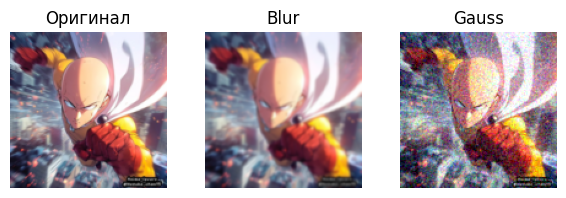

In [ ]:
img, cls = class_samples[2]

images = []
titles = ['Blur', 'Gauss']

blur = transforms.Compose([
    RandomBlur(kernel_size_range=(3, 7)),
    transforms.ToTensor()
])
images.append(blur(img))

noise_aug = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.2)
])
images.append(noise_aug(img))


show_multiple_augmentations(transforms.ToTensor()(img), images, titles)

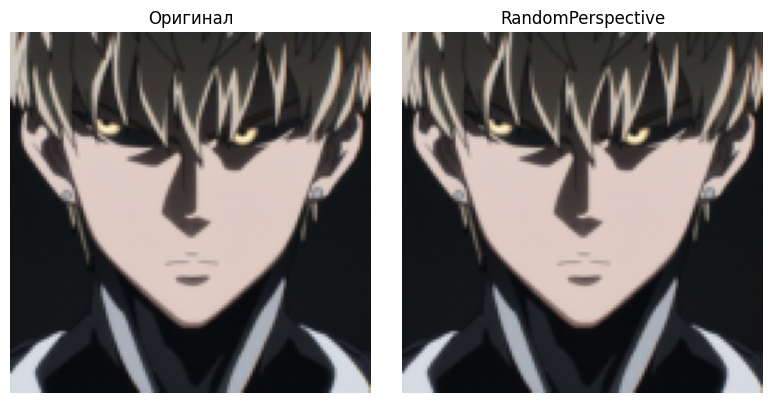

In [ ]:
img, cls = dataset[44]

pers = transforms.Compose([
    RandomPerspective(distortion_scale=0.3),
    transforms.ToTensor()
])

pers_img = pers(img)
show_single_augmentation(transforms.ToTensor()(img), pers_img, "RandomPerspective")

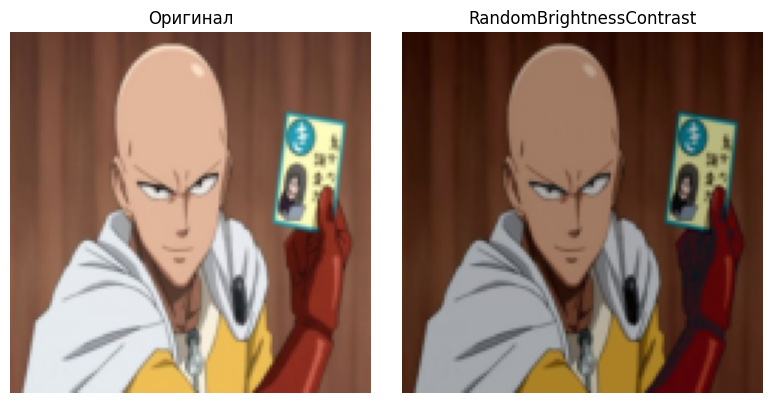

In [ ]:
img, cls = dataset[66]

contrast = transforms.Compose([
    RandomBrightnessContrast(brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)),
    transforms.ToTensor()
])

contrast_img = contrast(img)
show_single_augmentation(transforms.ToTensor()(img), contrast_img, "RandomBrightnessContrast")

# Задание 3: Анализ датасета

 - Подсчитайте количество изображений в каждом классе.

 - Найдите минимальный, максимальный и средний размеры изображений.

 - Визуализируйте распределение размеров и гистограмму по классам.


In [ ]:
def get_dataset_stats(dataset):
    """Собирает статистику о датасете"""
    class_counts = defaultdict(int)
    sizes = []
    min_h, min_w = float('inf'), float('inf')
    max_h, max_w = 0, 0

    for img_path, cls_name in zip(dataset.images, dataset.labels):
        class_counts[cls_name] += 1

        with Image.open(img_path) as img:
            width, height = img.size
            if width * height < min_h * min_w:
                min_w, min_h = width, height
            elif width * height > max_h * max_w:
                max_w, max_h = width, height
            sizes.append(img.size)

    return class_counts, sizes, min_w, min_h, max_w, max_h

def print_stats(class_counts, sizes, min_w, min_h, max_w, max_h):
    """Выводит статистику датасета"""
    # Статистика по размерам
    widths = [w for w, h in sizes]
    heights = [h for w, h in sizes]
    areas = [w * h for w, h in sizes]

    print("\nСтатистика размеров изображений:")
    print(f"Всего изображений: {len(sizes)}")
    print(f"Минимальный размер: {min_w}x{min_h}")
    print(f"Максимальный размер: {max_w}x{max_h}")
    print(f"Средний размер: {np.mean(widths):.1f}x{np.mean(heights):.1f}")
    print(f"Медианный размер: {np.median(widths):.1f}x{np.median(heights):.1f}")

def visualize_stats(class_counts, sizes):
    """Визуализирует статистику датасета"""
    plt.figure(figsize=(18, 5))

    # 1. Гистограмма по классам
    plt.subplot(1, 3, 1)
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Распределение по классам')
    plt.xlabel('Классы')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

    # 2. Размеры изображений
    plt.subplot(1, 3, 2)
    widths, heights = zip(*sizes)
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Размеры изображений')
    plt.xlabel('Ширина (px)')
    plt.ylabel('Высота (px)')

    # 3. Гистограмма площадей
    plt.subplot(1, 3, 3)
    areas = [w * h for w, h in sizes]
    plt.hist(areas, bins=30)
    plt.title('Распределение площадей')
    plt.xlabel('Площадь (px²)')
    plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()


Статистика размеров изображений:
Всего изображений: 180
Минимальный размер: 210x240
Максимальный размер: 736x1308
Средний размер: 538.9x623.6
Медианный размер: 564.0x564.0


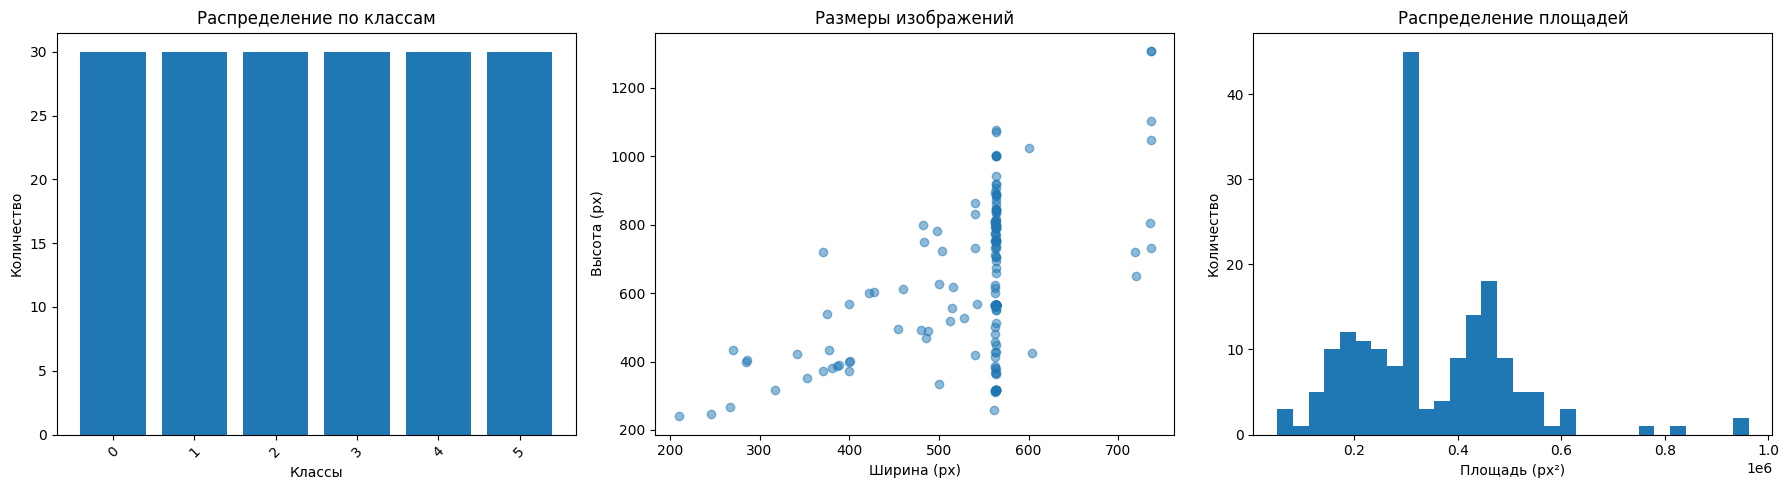

In [ ]:
class_counts, sizes, min_w, min_h, max_w, max_h  = get_dataset_stats(dataset)
# Выводим информацию
print_stats(class_counts, sizes, min_w, min_h, max_w, max_h)
# Визуализируем
visualize_stats(class_counts, sizes)

# Задание 4: Pipeline аугментаций

Реализуйте класс AugmentationPipeline с методами:

 - add_augmentation(name, aug)
 - remove_augmentation(name)
 - apply(image)
 - get_augmentations()

Создайте несколько конфигураций (light, medium, heavy).

Примените каждую конфигурацию к train и сохраните результаты.




In [ ]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentations = {}

    def add_augmentation(self, name, aug):
        """Добавляет аугментацию в пайплайн"""
        self.augmentations[name] = aug

    def remove_augmentation(self, name):
        """Удаляет аугментацию из пайплайна"""
        if name in self.augmentations:
            del self.augmentations[name]

    def apply(self, image):
        """Применяет все аугментации к изображению последовательно"""
        augmented = image
        for aug_name, aug in self.augmentations.items():
            augmented = aug(augmented)
        return augmented

    def get_augmentations(self):
        """Возвращает словарь всех аугментаций"""
        return self.augmentations.copy()

    @staticmethod
    def create_light_config():
        """Создает легкую конфигурацию аугментаций"""
        pipeline = AugmentationPipeline()
        pipeline.add_augmentation("brightness_contrast", RandomBrightnessContrast(
            brightness_range=(0.9, 1.1),
            contrast_range=(0.9, 1.1)
        ))
        pipeline.add_augmentation("random_blur", RandomBlur(
            kernel_size_range=(3, 5)
        ))
        return pipeline

    @staticmethod
    def create_medium_config():
        """Создает среднюю конфигурацию аугментаций"""
        pipeline = AugmentationPipeline()
        pipeline.add_augmentation("brightness_contrast", RandomBrightnessContrast(
            brightness_range=(0.8, 1.2),
            contrast_range=(0.8, 1.2)
        ))
        pipeline.add_augmentation("random_blur", RandomBlur(
            kernel_size_range=(3, 7)
        ))
        pipeline.add_augmentation("gaussian_noise", AddGaussianNoise(
            mean=0., std=0.05
        ))
        return pipeline

    @staticmethod
    def create_heavy_config():
        """Создает тяжелую конфигурацию аугментаций"""
        pipeline = AugmentationPipeline()
        pipeline.add_augmentation("brightness_contrast", RandomBrightnessContrast(
            brightness_range=(0.7, 1.3),
            contrast_range=(0.7, 1.3)
        ))
        pipeline.add_augmentation("random_blur", RandomBlur(
            kernel_size_range=(3, 9)
        ))
        pipeline.add_augmentation("gaussian_noise", AddGaussianNoise(
            mean=0., std=0.1
        ))
        pipeline.add_augmentation("random_erase", RandomErasingCustom(
            p=0.5, scale=(0.02, 0.2)
        ))
        pipeline.add_augmentation("cutout", CutOut(
            p=0.5, size=(32, 32)
        ))
        pipeline.add_augmentation("elastic", ElasticTransform(
            p=0.5, alpha=1, sigma=50
        ))
        return pipeline

In [ ]:
def save_augmented_samples(dataset, pipeline, output_dir, samples_per_class=3):
    """
    Сохраняет примеры аугментированных изображений для визуализации

    Args:
        dataset: CustomImageDataset
        pipeline: AugmentationPipeline
        output_dir: Папка для сохранения результатов
        samples_per_class: Количество примеров на класс
    """
    os.makedirs(output_dir, exist_ok=True)

    # Собираем индексы для каждого класса
    class_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    # Для каждого класса выбираем samples_per_class случайных изображений
    for class_idx, indices in class_indices.items():
        class_name = dataset.classes[class_idx]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        selected_indices = random.sample(indices, min(samples_per_class, len(indices)))

        for i, idx in enumerate(selected_indices):
            image, _ = dataset[idx]

            # Сохраняем оригинал
            original_path = os.path.join(class_dir, f"original_{i}.jpg")
            image.save(original_path)

            # Применяем аугментации и сохраняем
            augmented_image = pipeline.apply(image)
            augmented_path = os.path.join(class_dir, f"augmented_{i}.jpg")

            if isinstance(augmented_image, torch.Tensor):
                # Конвертируем тензор обратно в PIL Image для сохранения
                augmented_image = transforms.ToPILImage()(augmented_image)

            augmented_image.save(augmented_path)

def create_augmented_datasets(base_dataset, configs):
    """
    Создает версии датасета с разными аугментациями

    Args:
        base_dataset: Исходный датасет без аугментаций
        configs: Словарь с конфигурациями аугментаций {'name': pipeline}

    Returns:
        Словарь с аугментированными датасетами {'name': dataset}
    """
    augmented_datasets = {}

    for name, pipeline in configs.items():
        # Создаем трансформ, который будет применять наш пайплайн
        transform = transforms.Lambda(lambda img: pipeline.apply(img))

        # Создаем копию датасета с новым трансформом
        augmented_dataset = CustomImageDataset(
            root_dir=base_dataset.root_dir,
            transform=transform,
            target_size=base_dataset.target_size
        )

        augmented_datasets[name] = augmented_dataset

        # Сохраняем примеры аугментаций
        save_augmented_samples(
            base_dataset,
            pipeline,
            os.path.join("augmentation_examples", name)
        )

    return augmented_datasets

In [ ]:
# Создаем конфигурации аугментаций
configs = {
  "light": AugmentationPipeline.create_light_config(),
  "medium": AugmentationPipeline.create_medium_config(),
  "heavy": AugmentationPipeline.create_heavy_config()
}

# Создаем аугментированные датасеты
augmented_datasets = create_augmented_datasets(dataset, configs)

# Теперь у вас есть:
# - base_dataset: оригинальные данные без аугментаций
# - augmented_datasets['light']: легкие аугментации
# - augmented_datasets['medium']: средние аугментации
# - augmented_datasets['heavy']: сильные аугментации

print("Аугментированные датасеты успешно созданы!")
print(f"Доступные конфигурации: {list(augmented_datasets.keys())}")

Аугментированные датасеты успешно созданы!
Доступные конфигурации: ['light', 'medium', 'heavy']


# Задание 5: Эксперимент с размерами

Проведите эксперимент с разными размерами изображений (например, 64x64, 128x128, 224x224, 512x512).

Для каждого размера измерьте время загрузки и применения аугментаций к 100 изображениям, а также потребление памяти.

Постройте графики зависимости времени и памяти от размера.


# Задание 6: Дообучение предобученных моделей

Возьмите одну из предобученных моделей torchvision (например, resnet18, efficientnet_b0, mobilenet_v3_small).

Замените последний слой на количество классов вашего датасета.

Дообучите модель на train, проверьте качество на val.

Визуализируйте процесс обучения (loss/accuracy).


In [ ]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [ ]:
def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    AddGaussianNoise(
            mean=0.,
            std=0.05
        ),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Для валидации - только ресайз и нормализация
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Загрузка данных
train_root = './drive/MyDrive/hero_dataset/test/'
train_dataset = CustomImageDataset(train_root, transform=transform)

test_root = './drive/MyDrive/hero_dataset/train/'
test_dataset = CustomImageDataset(test_root, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Загрузка предобученной модели
model = models.resnet18(weights='IMAGENET1K_V1')

# Замена последнего слоя
num_classes = len(train_dataset.get_class_names())
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Перенос модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

print("Training Resnet18...")
history = train_model(model, train_loader, test_loader, epochs=5, device=str(device))

Using device: cuda
Training Resnet18...


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch 1/5:
Train Loss: 1.2306, Train Acc: 0.5667
Test Loss: 12.1542, Test Acc: 0.4333
--------------------------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch 2/5:
Train Loss: 0.6824, Train Acc: 0.7500
Test Loss: 2.7548, Test Acc: 0.5278
--------------------------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch 3/5:
Train Loss: 0.4645, Train Acc: 0.8350
Test Loss: 0.7524, Test Acc: 0.7500
--------------------------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch 4/5:
Train Loss: 0.3489, Train Acc: 0.8800
Test Loss: 0.7915, Test Acc: 0.7889
--------------------------------------------------


100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

Epoch 5/5:
Train Loss: 0.2705, Train Acc: 0.9083
Test Loss: 0.7368, Test Acc: 0.7833
--------------------------------------------------


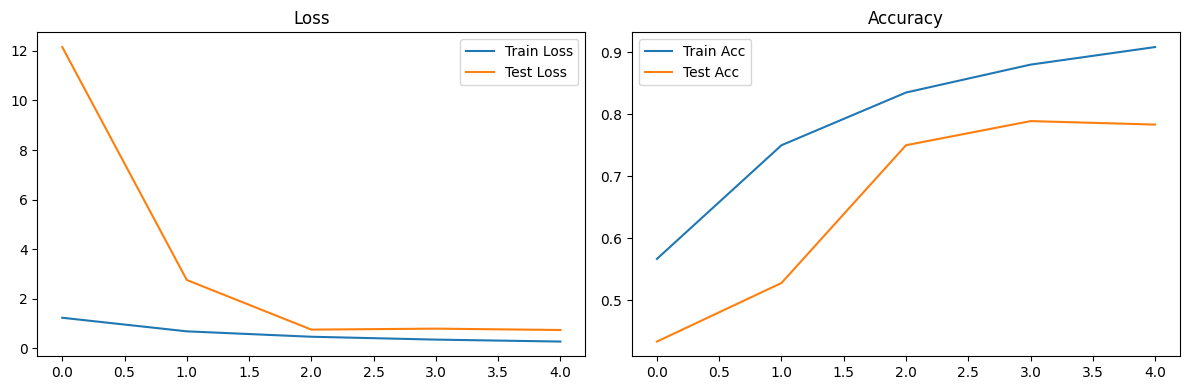

In [ ]:
plot_training_history(history)